In [1]:
!kaggle datasets download osmankagankurnaz/acne-dataset-in-yolov8-format

Dataset URL: https://www.kaggle.com/datasets/osmankagankurnaz/acne-dataset-in-yolov8-format
License(s): apache-2.0
 97% 33.0M/33.9M [00:03<00:00, 13.5MB/s]
100% 33.9M/33.9M [00:03<00:00, 11.1MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/acne-dataset-in-yolov8-format.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
!pip install keras-cv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.9 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO
import numpy as np
import random

#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns

#
import wandb
wandb.init(mode="disabled")
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
train_path='/content/data-2/train'
test_path='/content/data-2/test'
val_path='/content/data-2/valid'

In [7]:
train_images = os.listdir(train_path+'/images')
test_images = os.listdir(test_path+'/images')
val_images = os.listdir(val_path+'/images')
train_labels = os.listdir(train_path+'/labels')
test_labels = os.listdir(test_path+'/labels')
val_labels = os.listdir(val_path+'/labels')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_val_images = len(val_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)
num_val_labels = len(val_labels)

print('images train: ',num_train_images,', images test: ', num_test_images,', images val: ', num_val_images, )
print('labels train: ',num_train_labels,', labels test: ', num_test_labels,', labels val: ', num_val_labels, )

images train:  823 , images test:  48 , images val:  56
labels train:  823 , labels test:  48 , labels val:  56


In [8]:
def train_val_generators(train_dir, validation_dir, test_dir):
  train_datagen = ImageDataGenerator(rescale=1./255.)

  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  validation_datagen = ImageDataGenerator(rescale=1./255.)
  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))
  test_datagen = ImageDataGenerator(rescale=1./255.)
  test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
  return train_generator, validation_generator, test_generator

In [9]:
training_dir='/content/data-2/train'
validation_dir='/content/data-2/valid'
test_dir='/content/data-2/test'
train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, test_dir)

Found 823 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


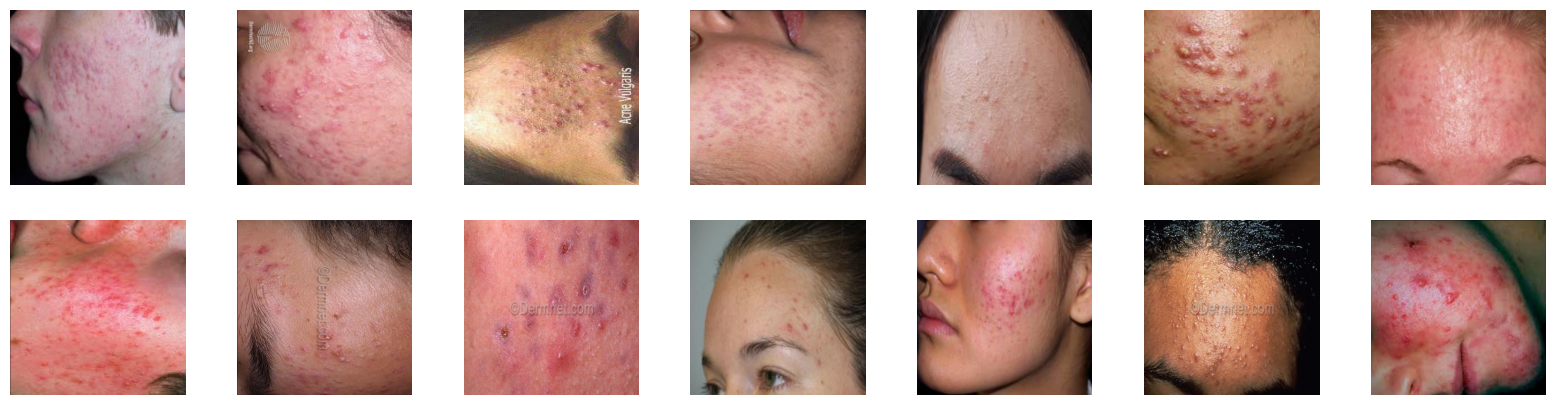

In [10]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(train_images),size=14),start=1):
  plt.subplot(2,7,i)
  # im=plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c])) # Removed this line
  # plt.imshow(im , cmap='gray') # Removed this line
  # Directly display the image using mpimg.imread with cmap='gray'
  plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c]), cmap='gray')
  plt.axis('off')
plt.show()

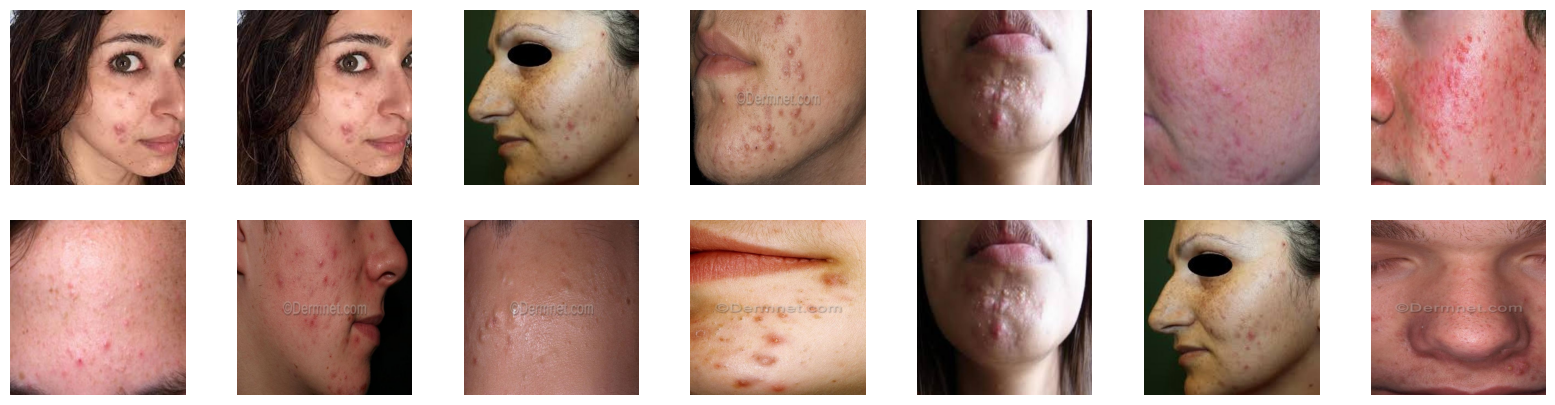

In [11]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(test_images),size=14),start=1):
  plt.subplot(2,7,i)
  plt.imshow(mpimg.imread(test_path+'/images/'+test_images[c]),cmap='gray')
  plt.axis('off')

plt.show()

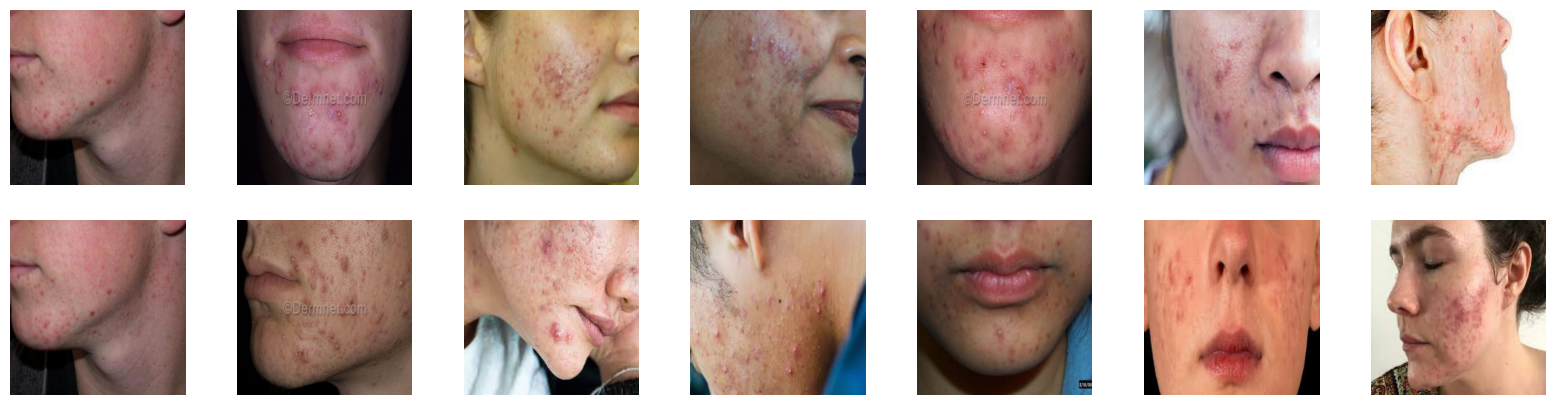

In [12]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(val_images),size=14),start=1):
  plt.subplot(2,7,i)
  plt.imshow(mpimg.imread(val_path+'/images/'+val_images[c]),cmap='gray')
  plt.axis('off')

plt.show()

In [13]:
model=YOLO('yolov8n.yaml')

In [14]:
results=model.train(data=('/content/data-2/data.yaml'),epochs=100, imgsz=640)

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/data-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 387MB/s]


AMP: checks passed ✅


train: Scanning /content/data-2/train/labels... 823 images, 12 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<00:00, 841.05it/s]

train: New cache created: /content/data-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/data-2/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 460.21it/s]

val: New cache created: /content/data-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.81G      5.346      3.852      3.938        115        640: 100%|██████████| 52/52 [00:21<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         56        643   0.000238    0.00622   0.000122   5.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.01G      3.584      2.609      2.859         51        640: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         56        643      0.182      0.103     0.0489     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.66G       2.96      2.204      2.259         68        640: 100%|██████████| 52/52 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         56        643      0.327       0.33      0.256     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.83G      2.726      2.044          2         95        640: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         56        643      0.344      0.397      0.273     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         3G        2.6      1.968        1.9         45        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         56        643       0.28      0.389      0.266     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.62G      2.502      1.894       1.78        257        640: 100%|██████████| 52/52 [00:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.421      0.412       0.38      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.74G      2.437      1.855      1.717        122        640: 100%|██████████| 52/52 [00:21<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all         56        643       0.37      0.438      0.345      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.8G      2.355      1.772      1.658        156        640: 100%|██████████| 52/52 [00:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         56        643      0.496      0.443      0.427      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.96G      2.328      1.775      1.621        144        640: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         56        643      0.397      0.377       0.34      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.53G      2.289      1.736      1.601        205        640: 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         56        643      0.389       0.46      0.361      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.88G      2.259      1.724      1.579        135        640: 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         56        643      0.423      0.471      0.418      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.15G      2.228      1.707      1.562        127        640: 100%|██████████| 52/52 [00:16<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         56        643      0.427      0.502      0.377       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.95G       2.23      1.709      1.555        118        640: 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         56        643      0.467      0.519      0.492      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.81G      2.223      1.688      1.533        123        640: 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         56        643      0.454      0.505       0.44      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.31G      2.187      1.698      1.539        127        640: 100%|██████████| 52/52 [00:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         56        643      0.474      0.527      0.489        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.87G      2.166      1.697      1.518         74        640: 100%|██████████| 52/52 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.487      0.445      0.455      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.97G      2.146      1.632      1.487         98        640: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         56        643      0.497      0.526      0.508      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.76G      2.137      1.616      1.489        138        640: 100%|██████████| 52/52 [00:17<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         56        643      0.455      0.464      0.419      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.85G      2.125      1.623       1.48         85        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         56        643      0.536      0.495      0.516       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.06G      2.097       1.63       1.46        106        640: 100%|██████████| 52/52 [00:16<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         56        643      0.482      0.465      0.448      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.71G      2.128       1.62      1.483         85        640: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         56        643      0.511      0.498      0.499      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.68G      2.116      1.633      1.475         94        640: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         56        643      0.527      0.474      0.499      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.85G      2.082       1.58      1.455        103        640: 100%|██████████| 52/52 [00:19<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         56        643      0.449      0.501      0.457      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.61G      2.083      1.603      1.457         77        640: 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         56        643      0.474      0.504      0.429      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.07G       2.06      1.579      1.444        117        640: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         56        643      0.574      0.529      0.548      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.76G      2.058      1.565      1.418        137        640: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         56        643      0.509      0.516      0.478      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.84G      2.066      1.585      1.433        112        640: 100%|██████████| 52/52 [00:16<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         56        643      0.508      0.473      0.469      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.19G       2.03      1.563      1.414        136        640: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         56        643      0.578      0.504      0.555      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.93G      2.052      1.555      1.415        118        640: 100%|██████████| 52/52 [00:16<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         56        643      0.491      0.512      0.488      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.54G       2.04      1.573      1.421        214        640: 100%|██████████| 52/52 [00:15<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         56        643      0.553      0.521       0.54      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.75G      2.048      1.561      1.413         98        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         56        643       0.46       0.51      0.467      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.85G      2.051      1.549      1.414        105        640: 100%|██████████| 52/52 [00:15<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         56        643      0.529      0.527      0.521      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.19G      2.018      1.551      1.408        103        640: 100%|██████████| 52/52 [00:15<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         56        643      0.566      0.551      0.542      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.66G      1.999      1.532      1.393        122        640: 100%|██████████| 52/52 [00:15<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        643      0.567      0.549      0.571      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.08G       1.99      1.524       1.37         86        640: 100%|██████████| 52/52 [00:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         56        643      0.523      0.521      0.508       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.63G      2.011      1.521      1.395        173        640: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         56        643      0.549      0.529      0.556      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.9G          2      1.524      1.376        287        640: 100%|██████████| 52/52 [00:14<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         56        643      0.579      0.554       0.57      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.86G      1.966      1.488      1.382         84        640: 100%|██████████| 52/52 [00:14<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        643      0.531      0.533      0.548      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.41G      1.999      1.497      1.378        138        640: 100%|██████████| 52/52 [00:14<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         56        643      0.548      0.489      0.521      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.47G      1.963      1.497      1.369        145        640: 100%|██████████| 52/52 [00:14<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        643      0.555      0.544      0.568      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.95G      1.987      1.485      1.377        127        640: 100%|██████████| 52/52 [00:14<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         56        643      0.558      0.547      0.542      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.83G      1.969      1.514      1.368         51        640: 100%|██████████| 52/52 [00:14<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        643       0.57      0.527      0.552       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.78G      1.962      1.474      1.357        153        640: 100%|██████████| 52/52 [00:15<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         56        643      0.601      0.558      0.578      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.69G       1.95      1.477      1.353        140        640: 100%|██████████| 52/52 [00:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         56        643      0.485      0.479       0.47      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.17G      1.948      1.498      1.361         70        640: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         56        643      0.511       0.53      0.541      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.76G      1.958      1.481      1.344        100        640: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         56        643      0.563      0.566      0.571      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.76G      1.967       1.48      1.357        200        640: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         56        643      0.545      0.545      0.561      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.84G       1.93      1.464       1.35        124        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         56        643       0.56      0.527      0.541      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.61G      1.949      1.469       1.36        130        640: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         56        643      0.573      0.523      0.542      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.08G      1.929      1.466      1.336        106        640: 100%|██████████| 52/52 [00:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         56        643       0.56      0.538       0.56       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.59G      1.903      1.441      1.327         54        640: 100%|██████████| 52/52 [00:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         56        643      0.581      0.533      0.564      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.1G      1.938      1.482      1.355        146        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         56        643      0.588      0.526       0.57      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.5G      1.906      1.447      1.336         99        640: 100%|██████████| 52/52 [00:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         56        643      0.612      0.579      0.603      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.61G      1.915      1.431       1.32        203        640: 100%|██████████| 52/52 [00:16<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         56        643      0.561      0.535      0.547      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.63G      1.923      1.433       1.34        123        640: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         56        643      0.578      0.566      0.568      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.88G      1.899      1.421      1.322        105        640: 100%|██████████| 52/52 [00:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         56        643      0.546      0.538      0.539      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.79G      1.912       1.45      1.321        131        640: 100%|██████████| 52/52 [00:17<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         56        643      0.506      0.524      0.502      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.92G      1.912      1.434      1.333        144        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         56        643      0.609      0.544      0.592      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.63G      1.891      1.421      1.315        110        640: 100%|██████████| 52/52 [00:16<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         56        643      0.596      0.597      0.586      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.72G       1.89      1.402      1.299         95        640: 100%|██████████| 52/52 [00:17<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         56        643      0.643      0.543      0.586      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.68G      1.885      1.405      1.307         91        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         56        643      0.607      0.563      0.592      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.99G      1.904      1.412      1.321        183        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         56        643      0.574      0.546      0.564      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.09G      1.881      1.404      1.311        165        640: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         56        643      0.585      0.573      0.582      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.76G      1.877      1.409      1.328         80        640: 100%|██████████| 52/52 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         56        643      0.589      0.583      0.591      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.03G       1.89      1.401      1.313        125        640: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         56        643      0.598      0.549      0.583      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.7G      1.889      1.392      1.313         95        640: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         56        643      0.561      0.568      0.569      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.49G      1.873      1.407      1.301        125        640: 100%|██████████| 52/52 [00:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         56        643      0.567      0.562      0.568      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.49G      1.875      1.381      1.298        114        640: 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         56        643      0.618      0.514      0.558      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.77G      1.864      1.383      1.297        146        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         56        643      0.612      0.531      0.582      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.79G      1.867      1.374      1.288        119        640: 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         56        643      0.575       0.58      0.581      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.6G      1.861      1.395      1.307         60        640: 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         56        643      0.593      0.571      0.586      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.06G      1.864       1.37      1.298        161        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         56        643        0.6       0.54      0.566      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.55G      1.851      1.355      1.295        103        640: 100%|██████████| 52/52 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         56        643       0.66      0.513      0.598      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.89G      1.831      1.391      1.298         72        640: 100%|██████████| 52/52 [00:16<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         56        643      0.593      0.575      0.595      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.12G      1.856      1.362      1.284        155        640: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         56        643      0.601      0.546      0.582      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.56G      1.834      1.347      1.285        109        640: 100%|██████████| 52/52 [00:15<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.599      0.565      0.588      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.72G      1.838      1.353      1.278         98        640: 100%|██████████| 52/52 [00:16<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         56        643      0.602      0.537      0.569      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.89G      1.847      1.365      1.281        103        640: 100%|██████████| 52/52 [00:17<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         56        643      0.593      0.542      0.556      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.98G      1.825      1.332      1.268        105        640: 100%|██████████| 52/52 [00:21<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         56        643      0.559      0.566      0.572      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.76G      1.836      1.355      1.284        133        640: 100%|██████████| 52/52 [00:16<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         56        643      0.614      0.556      0.587      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.61G      1.831      1.359      1.278         84        640: 100%|██████████| 52/52 [00:17<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         56        643      0.597      0.502      0.542       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.9G      1.822      1.336      1.277        121        640: 100%|██████████| 52/52 [00:16<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         56        643      0.584      0.529      0.564      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.84G      1.828      1.328      1.277        159        640: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         56        643      0.607      0.535      0.561      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.8G      1.825      1.317      1.273        108        640: 100%|██████████| 52/52 [00:16<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         56        643      0.598       0.56      0.592      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.82G      1.834      1.323      1.266        171        640: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         56        643      0.606      0.549      0.585      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         3G      1.816      1.321      1.274        138        640: 100%|██████████| 52/52 [00:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         56        643      0.617       0.58      0.605      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.99G      1.813      1.302      1.261        156        640: 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         56        643      0.617       0.57      0.601      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.98G      1.823      1.313      1.262        195        640: 100%|██████████| 52/52 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         56        643      0.604      0.568       0.58      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.84G      1.817      1.301      1.264         91        640: 100%|██████████| 52/52 [00:17<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.653       0.56      0.606      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.84G      1.803      1.306       1.26        125        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         56        643      0.623       0.58      0.598      0.266


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.61G      1.773      1.331       1.29        110        640: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         56        643      0.612      0.565      0.595      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.72G       1.77      1.312      1.293        108        640: 100%|██████████| 52/52 [00:16<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         56        643      0.633      0.533      0.588      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.74G      1.765      1.288      1.289         72        640: 100%|██████████| 52/52 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         56        643      0.605      0.563      0.587      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.57G      1.753       1.28      1.285        156        640: 100%|██████████| 52/52 [00:18<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         56        643      0.637      0.566      0.603      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.85G      1.742      1.282      1.294         73        640: 100%|██████████| 52/52 [00:16<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         56        643       0.64      0.574      0.612      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.58G      1.754      1.275      1.286         75        640: 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         56        643       0.63      0.561      0.601      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.44G      1.735      1.265       1.29         52        640: 100%|██████████| 52/52 [00:16<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.675      0.551      0.607      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.44G      1.738       1.28      1.294        117        640: 100%|██████████| 52/52 [00:15<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         56        643      0.645      0.552      0.591      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.73G      1.724      1.255       1.28         56        640: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         56        643      0.608      0.565      0.592      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.59G      1.734      1.237      1.282         95        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         56        643      0.628      0.555      0.592      0.265



100 epochs completed in 0.527 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


                   all         56        643      0.672      0.551      0.606      0.273
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train


In [15]:
model.save("acne-computer-vision_model.pt")

In [16]:
import cv2

In [17]:
image_input=cv2.imread('/content/data-2/test/images/acne-57_jpeg.rf.b9ed02768080fdfcf648eef4e58c1904.jpg')

In [18]:
results = model.predict(source=image_input,conf=0.25,save=True)


0: 640x640 7 Acnes, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train2


In [19]:
results[0].boxes.xyxy

tensor([[228.3762, 360.4998, 268.0973, 424.7070],
        [318.6368, 320.9561, 354.7110, 371.2376],
        [332.5312,  71.3595, 362.4404, 113.6684],
        [296.2358, 119.7047, 326.3708, 164.0379],
        [359.1937, 289.2981, 389.3802, 337.4839],
        [261.4174, 418.6371, 290.8384, 469.3660],
        [216.5148,  99.9931, 246.7788, 147.3518]], device='cuda:0')

In [20]:
results[0].boxes.conf

tensor([0.7131, 0.6743, 0.6609, 0.5870, 0.5324, 0.4047, 0.3114], device='cuda:0')

In [21]:
results[0].boxes.cls

tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [22]:
classNames = ["Acne"]

In [24]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [25]:
!pip install cvzone
!pip install opencv-python

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=05e9dd0111960f1f8dacdf528b4b6c2cd2773c3dc47f0981b8fbab2a4472a347
  Stored in directory: /root/.cache/pip/wheels/ab/36/ec/47be2d4e59dc4289e684d5b0dde54d1e72e51a614e57690e85
Successfully built cvzone


In [27]:
import cv2
import cvzone
import math
from IPython.display import Image

In [32]:
results = model(image_input, stream=True)
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2-x1, y2-y1
        cvzone.cornerRect(image_input, (x1, y1, w, h))

        conf = math.ceil((box.conf[0]*100))/100

        cls = box.cls[0]
        name = classNames[int(cls)]

        cvzone.putTextRect(image_input, f'{name} 'f'{conf}', (max(0,x1), max(35,y1)), scale = 0.5)

cv2.imwrite('output.jpg', image_input)


0: 640x640 7 Acnes, 17.2ms
Speed: 6.4ms preprocess, 17.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


True

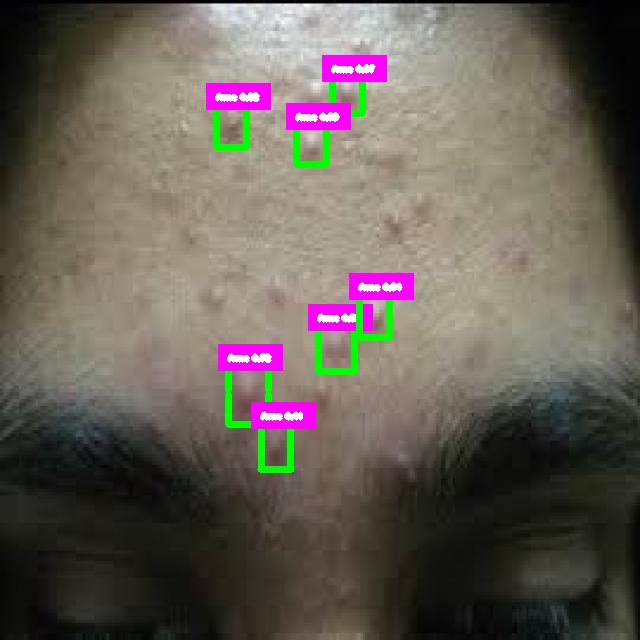

In [34]:
Image("/content/output.jpg")

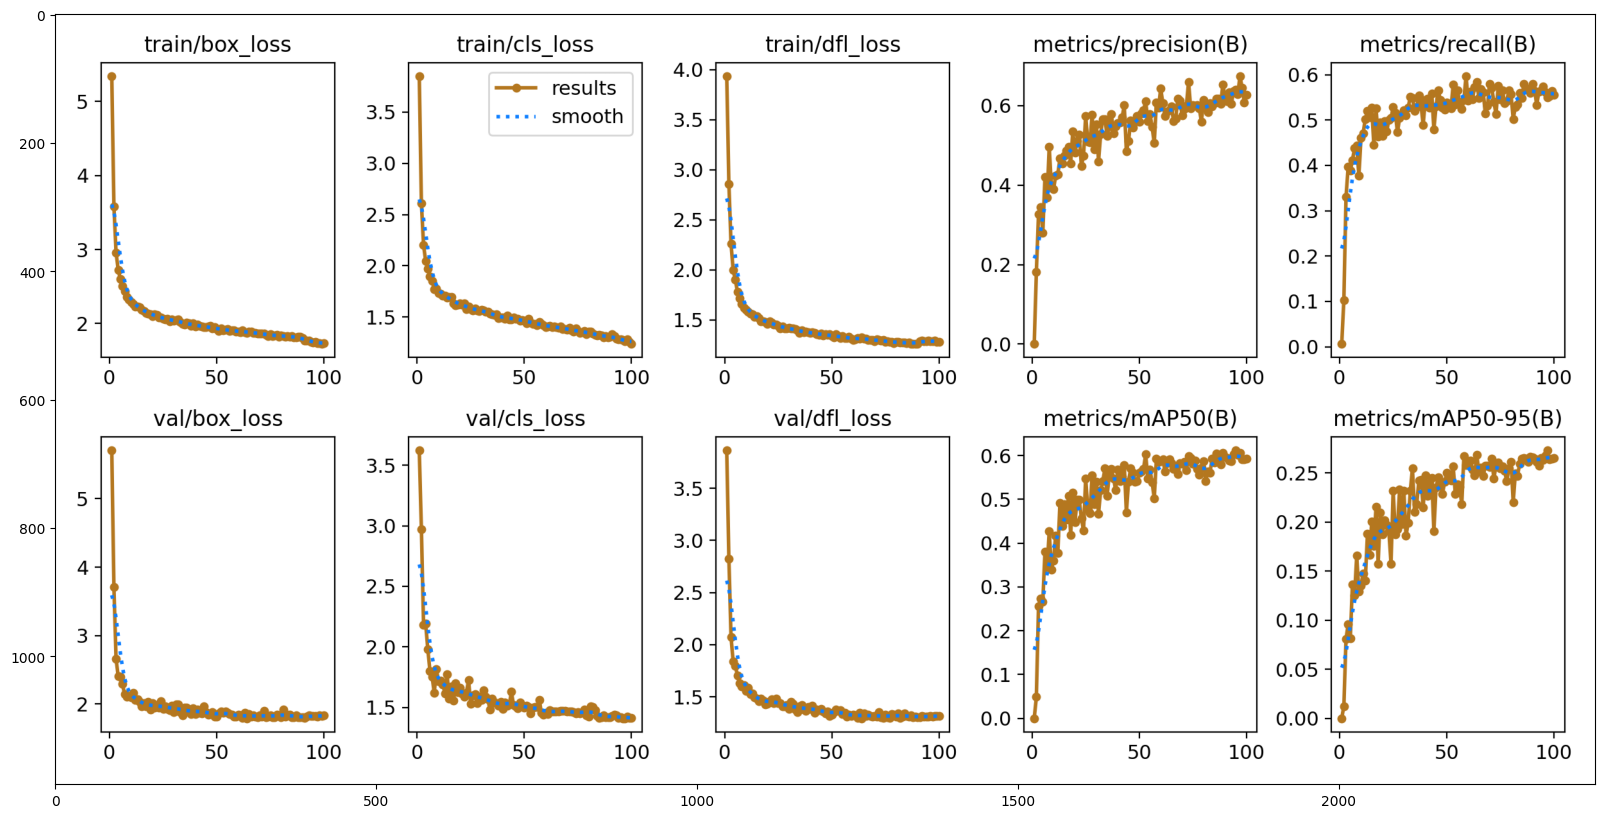

In [35]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train/results.png')
plt.imshow(img)
plt.show()

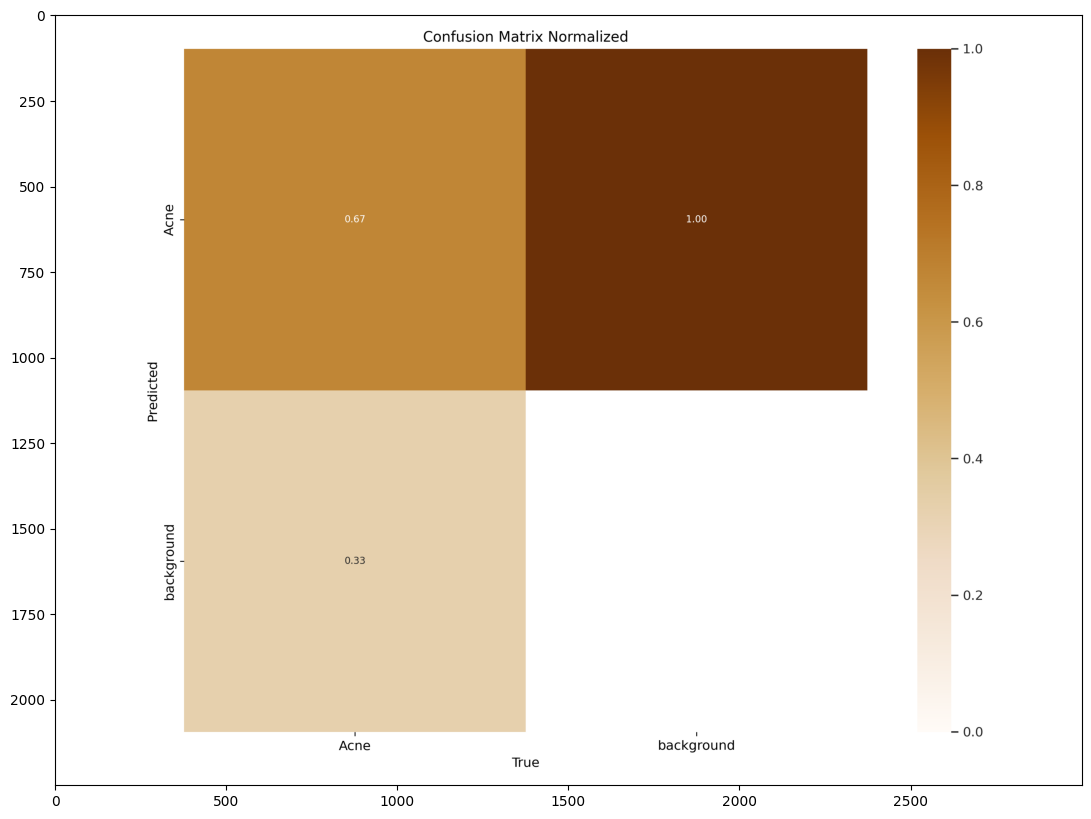

In [36]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train/confusion_matrix_normalized.png')
plt.imshow(img)
plt.show()

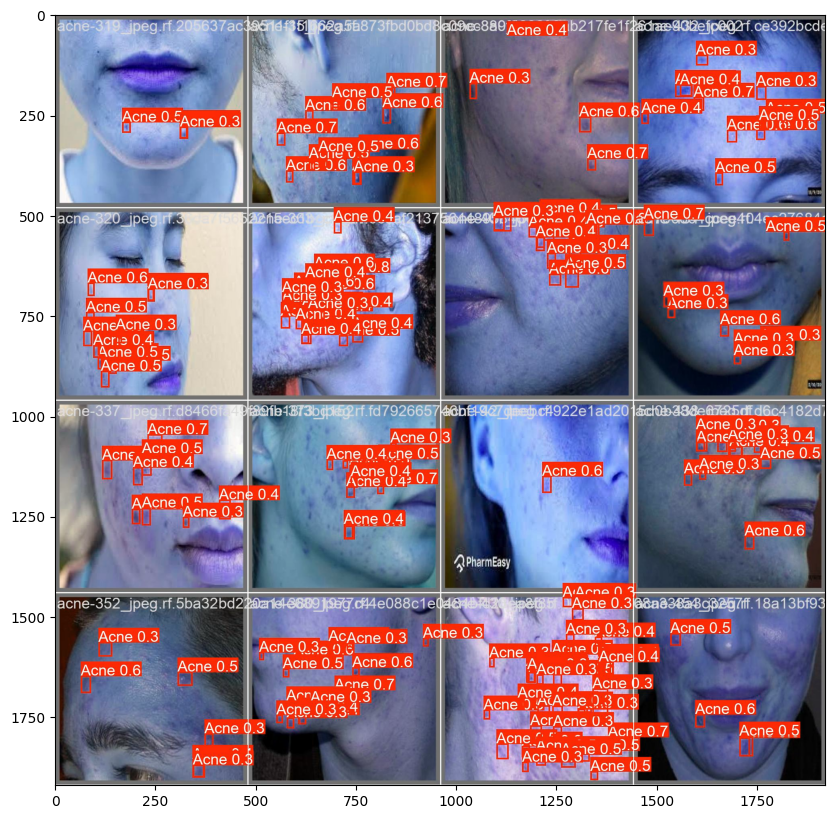

In [37]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train/val_batch1_pred.jpg')
plt.imshow(img)
plt.show()

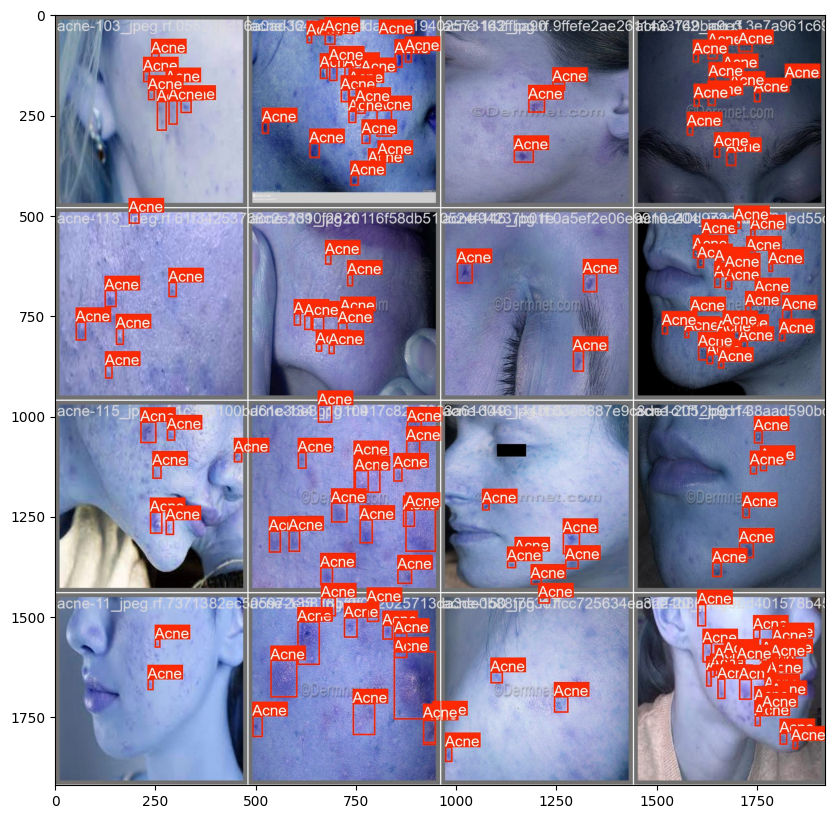

In [38]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train/val_batch0_labels.jpg')
plt.imshow(img)
plt.show()

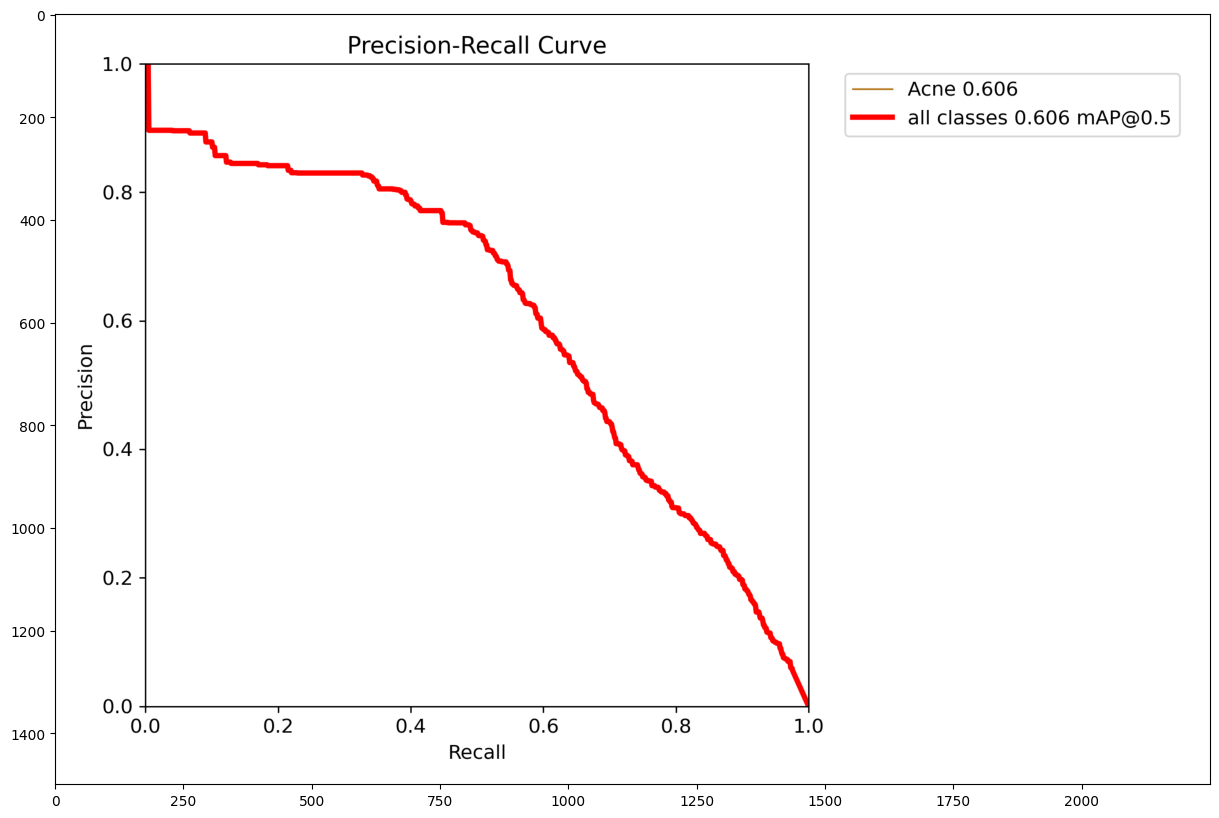

In [39]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train/PR_curve.png')
plt.imshow(img)
plt.show()

In [40]:
def Tumor_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img

In [41]:
import random


0: 640x640 7 Acnes, 23.1ms
Speed: 3.3ms preprocess, 23.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Acnes, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 20 Acnes, 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acnes, 14.6ms
Speed: 2.8ms preprocess, 14.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Acnes, 14.8ms
Speed: 2.9ms preprocess, 14.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 Acnes, 11.8ms
Speed: 3.1ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 Acnes, 22.4ms
Speed: 2.7ms preprocess, 22.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 22 Acnes, 14.2ms
Speed: 3.3ms preprocess, 14.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640

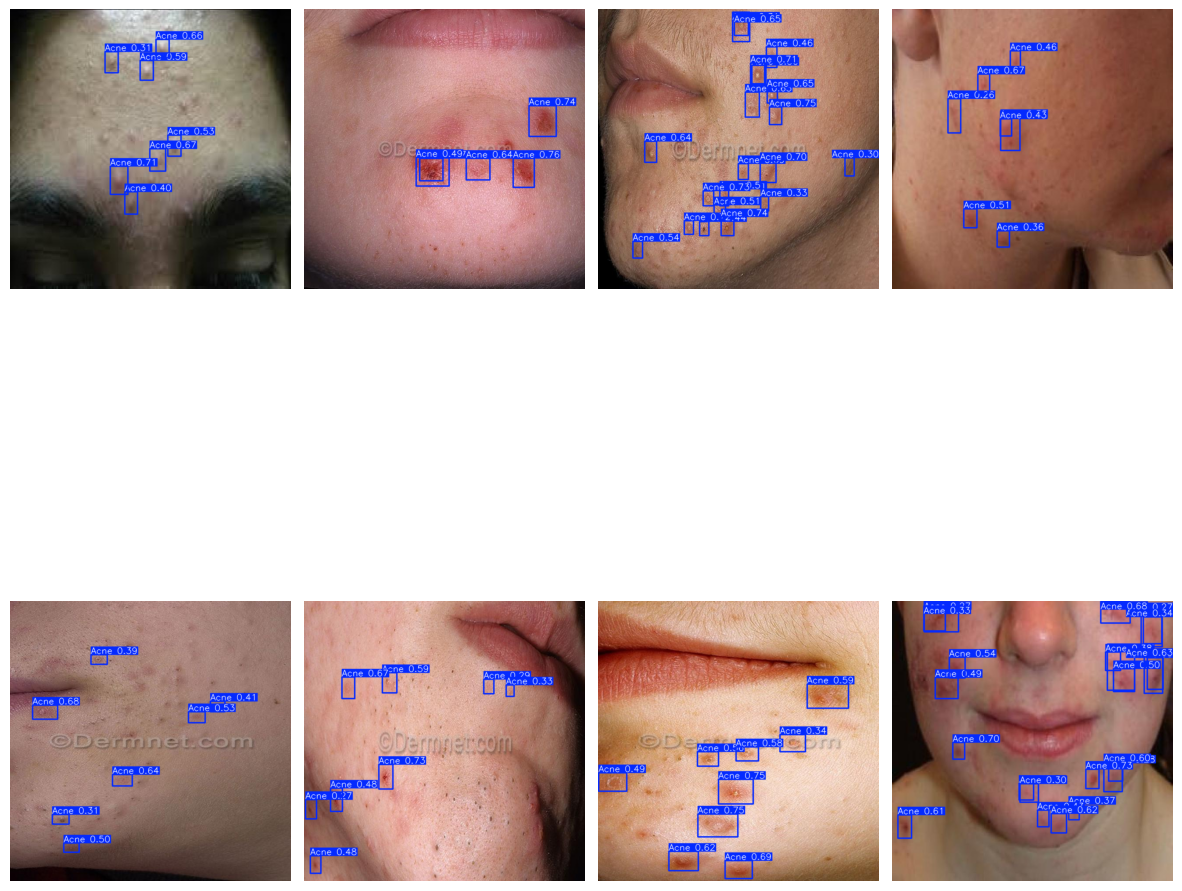

In [44]:
custom_image_dir = '/content/data-2/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = Tumor_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)